In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split # not used ????
from sklearn.metrics import mutual_info_score

from catboost import CatBoostClassifier

import shap
shap.initjs()

%matplotlib inline

In [2]:
def get_y(y, n=10):
    return ((np.angle((y.x + 1j * y.y).values) + np.pi) / 2 / np.pi * 10).astype(int)

In [3]:
def acc_1(y_pred, y_true):
    return np.sum(y_pred == y_true) / len(y_true)
def acc_3(y_pred, y_true, n=10):
    return np.sum(np.logical_or(np.abs(y_pred - y_test) <= 1., np.abs(y_pred - y_test) == n-1)) / len(y_true)

In [4]:
track = pd.read_csv('data/CA1_6_1_track.csv')
track.columns = ['time', 'x', 'y']
track = track.set_index('time')
track.index = (track.index * 20).astype(np.int32)

In [5]:
neuropil = pd.read_csv('data/CA1_6_1_neuropil.csv')
neuropil.columns = list(range(len(neuropil.columns)))
neuropil = neuropil.set_index(0)
neuropil.index = (neuropil.index * 20).astype(np.int32)

In [6]:
# why from index 645????

full_data = neuropil.iloc[645:].reset_index().drop([0], axis=1).join(track, how='inner').loc[10:]

In [7]:
full_data.head()

,1,2,3,4,5,6,7,8,9,10,...,583,584,585,586,587,588,589,590,x,y
10,-0.004962,-0.007518,0.002856,-0.002459,0.012671,0.004508,-0.002190,-0.003734,-0.000925,-0.002684,...,0.001980,-0.000420,0.006400,0.007676,0.003326,0.006363,-0.001662,-0.003236,-19.161957,5.008783
11,-0.005094,-0.005817,0.003220,0.000504,0.010845,0.002914,-0.003777,-0.005426,-0.001447,-0.005684,...,0.002795,0.001087,0.004594,0.006707,0.003611,0.004232,-0.000977,-0.000709,-20.055400,5.602721
12,-0.004959,-0.007381,0.002250,-0.001745,0.010025,-0.001474,-0.003159,-0.002456,0.000444,-0.003892,...,0.002975,0.002064,0.005655,0.007591,0.003341,0.005342,-0.000768,-0.001314,-19.999324,6.323581
13,-0.004731,-0.006127,0.002409,0.000073,0.007454,0.000138,-0.003104,-0.002373,-0.001115,-0.003947,...,0.002888,0.002873,0.005268,0.007248,-0.000298,0.007396,0.000361,-0.004089,-19.921652,7.028567
14,-0.005890,-0.007438,0.003455,-0.002265,0.010671,0.002261,-0.000498,-0.002451,-0.001143,-0.002059,...,0.003474,0.004536,0.006306,0.004947,0.001629,0.007965,0.000599,-0.002331,-19.838119,7.727636


In [8]:
fine_cells = pd.read_csv('data/CA1_6_1_fine_cells.csv')

# TODO just rename it
fine_cells['time'] = fine_cells['time,s\cell#']
fine_cells.drop(['time,s\cell#'], axis=1, inplace=True)
fine_cells.set_index('time', inplace=True)

# index does not corresond to full_data?
fine_cells.index = (fine_cells.index * 20).astype(np.int32)

In [9]:
# why do it here
# why not name it fine_columns
best_columns = fine_cells.columns.astype(int)

In [10]:
fine_cells.head()

,4,69,92,116,123,128,136,143,147,153,...,188,192,208,231,273,354,408,543,570,577
time,,,,,,,,,,,,,,,,,,,,,
1,0.018179,-0.024777,-0.006565,-0.012388,-0.008887,-0.012914,-0.015549,-0.006735,-0.012197,-0.018785,...,0.009529,-0.001906,0.043256,-0.005412,-0.001835,-0.004913,-0.006586,-0.005296,-0.007407,-0.002616
2,0.017365,-0.022071,-0.006246,-0.013401,-0.006372,-0.013255,-0.017807,-0.006125,-0.013311,-0.018717,...,0.012430,-0.000354,0.042603,-0.005423,-0.003040,-0.003705,-0.006257,-0.005749,-0.007352,-0.003265
3,0.017278,-0.022216,-0.004703,-0.009781,-0.005761,-0.011657,-0.013116,-0.010442,-0.011870,-0.017295,...,0.012656,0.001288,0.041309,-0.003618,-0.000195,-0.001868,-0.005974,-0.005802,-0.004829,-0.003245
4,0.013902,-0.021415,-0.003486,-0.010803,-0.003996,-0.014408,-0.015875,-0.009822,-0.010226,-0.019532,...,0.010340,0.001612,0.043249,-0.006278,-0.001035,-0.006251,-0.006020,-0.005568,-0.006260,-0.003475
5,0.015821,-0.022920,-0.000751,-0.011077,-0.001041,-0.012884,-0.014639,-0.008761,-0.013454,-0.017255,...,0.007611,0.005419,0.039358,-0.004703,-0.001926,-0.006696,-0.008204,-0.004500,-0.004808,-0.002429


In [11]:
X_cols = full_data.columns[:-2]
y_cols = full_data.columns[-2:]

In [12]:
X = full_data[X_cols]
y = get_y(full_data[y_cols])

In [13]:
# what is y
y_full = full_data[['x', 'y']].copy()
y_full['segment'] = y

In [14]:
y_full.head(3)

,x,y,segment
10,-19.161957,5.008783,9
11,-20.055400,5.602721,9
12,-19.999324,6.323581,9


In [15]:
y_full['segment'].unique()

array([9, 8, 7, 6, 5, 4, 3, 0, 1, 2])

In [16]:
# y is a segment...

In [17]:
x_max, y_max = y_full[['x', 'y']].max()
x_min, y_min = y_full[['x', 'y']].min()

In [18]:
x_max, y_max, x_min, y_min

(28.606523809523807,
 29.37579047619047,
 -21.157671428571426,
 -21.49106666666666)

In [19]:
radius_x = (x_max - x_min) / 2
radius_y = (y_max - y_min) / 2
radius = (radius_x+radius_y)/2

In [20]:
cx1 = x_max - radius
cx2 = x_min + radius
cx = (cx1 + cx2) / 2
cy1 = y_max - radius
cy2 = y_min + radius
cy = (cy1 + cy2) / 2

In [21]:
from math import pi
from math import cos, sin
def generate_xy(center, radius, n=100):
    """
    returns a list of n coordinates of a circle on xy plane

    Parameters
    ----------
    center : (x, y)
        center of the circle
    radius : float
        radius of the circle
    n : int
        number of points

    Returns
    -------
    list
        coordinates of the circle on xy plane (x, y)

    """
    a = [] # the resulting array
    delta = 2 * pi / n
    angles = np.arange(0, 2 * pi, delta)
    for phi in angles:
        x = radius * cos(phi) + center[0]
        y = radius * sin(phi) + center[1]
        a.append((x, y))
    return a

In [22]:
generated_circle = pd.DataFrame(generate_xy((cx, cy), radius, n=10**3),columns=['x','y'])
generated_circle['segment'] = get_y(generated_circle)
generated_circle.head(2)

,x,y,segment
0,28.882189,3.942362,5
1,28.881693,4.100432,5


In [23]:
generated_circle['segment'].unique()

array([5, 6, 7, 8, 9, 0, 1, 2, 3, 4])

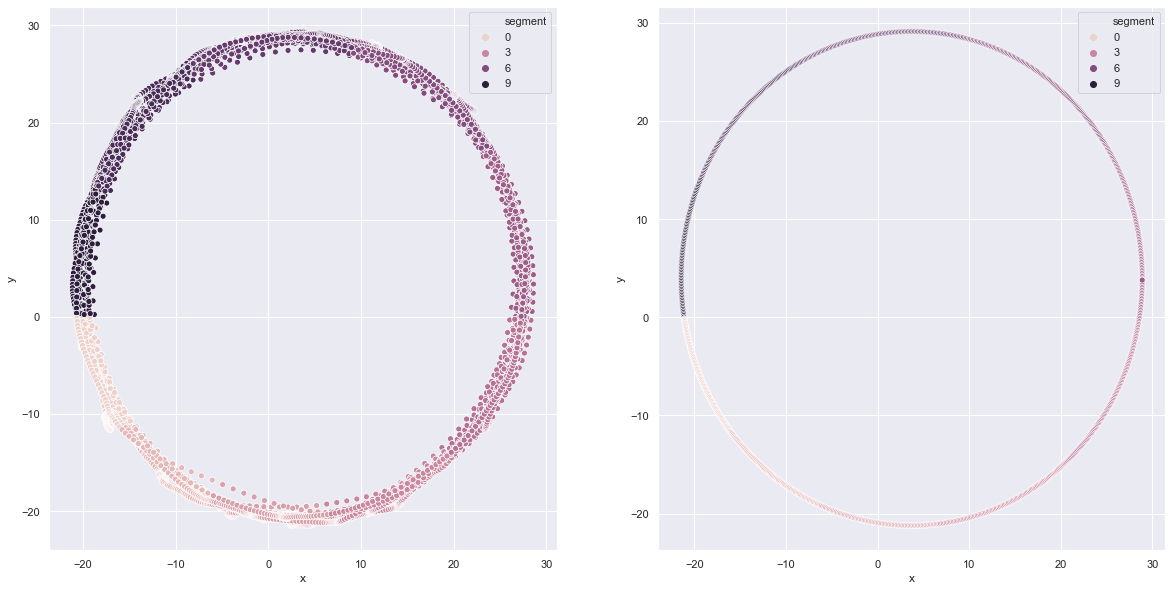

In [24]:
fig, axs = plt.subplots(figsize=(20, 10), ncols=2)
sns.scatterplot(x='x', y='y', hue='segment', data=y_full, ax=axs[0])
sns.scatterplot(x='x', y='y', hue='segment', data=generated_circle, ax=axs[1])

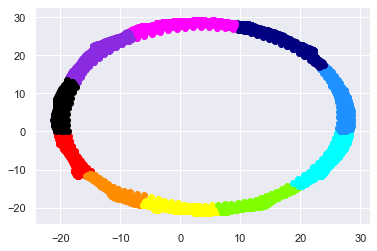

In [25]:
colors = {
    0: 'red',
    1: 'darkorange',
    2: 'yellow',
    3: 'chartreuse',
    4: 'cyan',
    5: 'dodgerblue',
    6: 'navy',
    7: 'fuchsia',
    8: 'blueviolet',
    9: 'black'
}
for s, c in colors.items():
    plt.scatter(x=y_full[y_full['segment']==s]['x'],
                y=y_full[y_full['segment']==s]['y'],
                c=c)

In [26]:
mis = dict()

In [27]:
for col in X.columns:
    # why not apply here
    quantiles = [X[col].quantile(q) for q in np.arange(0, 1, 0.1)]
    batches = np.zeros(len(y)).astype(int)
    for q in quantiles:
        batches += (X[col] - q >= 0)
    mis[col] = mutual_info_score(batches, y)

In [28]:
mutual_info_score(y, y) / np.log(2)

3.1136764800306898

In [29]:
# reverse=True???
# make a diagram
for col, mi in sorted(mis.items(), key=lambda x: -x[1]):
    print(col, mi / np.log(2))

120 0.6713816329191558
147 0.6588324029449011
382 0.6197021071799993
106 0.5821128231637169
77 0.577001462733999
397 0.5512336036885923
31 0.5465369834398437
383 0.5437278391606745
274 0.5370636352812777
158 0.5328195124931109
231 0.5272478124902299
129 0.5245196558730867
462 0.5241538908367942
154 0.5225330521499056
119 0.509896373243915
71 0.508895777950438
133 0.5073148638464373
344 0.5028826356615305
251 0.4983063754189065
93 0.487974812612755
391 0.48716938230592255
198 0.481886792819624
137 0.4717588100143141
247 0.4699233427235205
39 0.4671349664542284
405 0.46704140873798317
376 0.459096176263624
124 0.45879839853464605
227 0.45722770558886006
140 0.4510877588308909
171 0.4479116091340768
223 0.4420314209260226
232 0.4412914493414732
567 0.4360567394444467
557 0.43591711833056807
15 0.43565630719684273
316 0.43307491161027983
363 0.4234942498788937
193 0.4208905319196743
111 0.41870750175766597
378 0.41859693686306737
330 0.417910093303597
144 0.4156876555946284
108 0.414239737

In [30]:
# why not name it best_columns
cols = [col for col, _ in sorted(mis.items(), key=lambda x: -x[1])][:20]

In [31]:
worst_cols = [col for col, _ in sorted(mis.items(), key=lambda x: x[1])][:20]

In [32]:
best_columns

Int64Index([  4,  69,  92, 116, 123, 128, 136, 143, 147, 153, 161, 165, 170,
            176, 188, 192, 208, 231, 273, 354, 408, 543, 570, 577],
           dtype='int64')

In [33]:
cols

[120,
 147,
 382,
 106,
 77,
 397,
 31,
 383,
 274,
 158,
 231,
 129,
 462,
 154,
 119,
 71,
 133,
 344,
 251,
 93]

In [34]:
set(cols).intersection(set(best_columns + 1))

{93, 129, 154, 274}

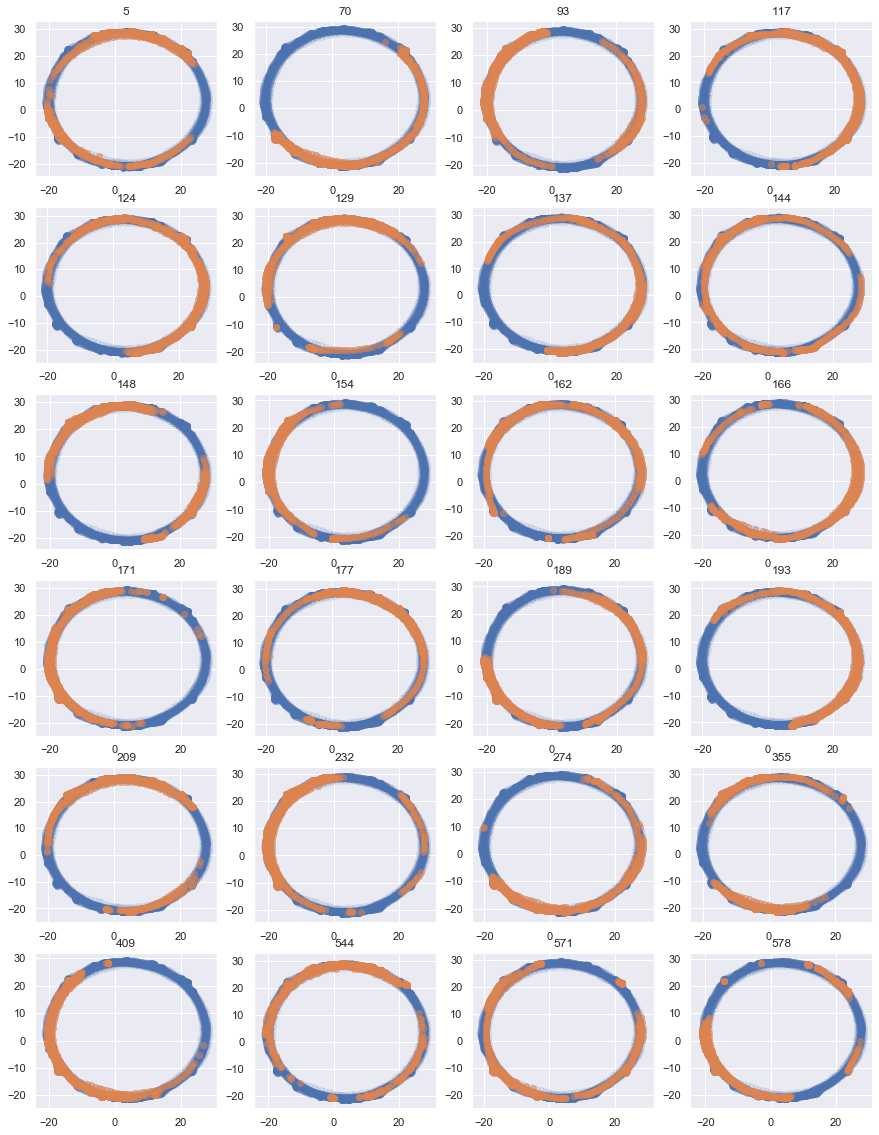

In [35]:
n = len(full_data)
new_data = full_data#.iloc[n // 2:]

quantiles = new_data[best_columns + 1].quantile(0.85)

plt.figure(figsize=(15, 20))
# plt.suptitle('Manualy selected neurons')

for i, col in enumerate(best_columns + 1):
    plt.subplot(6, 4, i + 1)
    plt.title(col)
    
    quantile = quantiles[col]
    active_state = (new_data[col] > quantile).values
    plt.scatter(new_data['x'], new_data['y'], alpha=0.1)
    plt.scatter(new_data[active_state].x, new_data[active_state].y, alpha=.5)
# plt.fig('Manualy selected neurons')

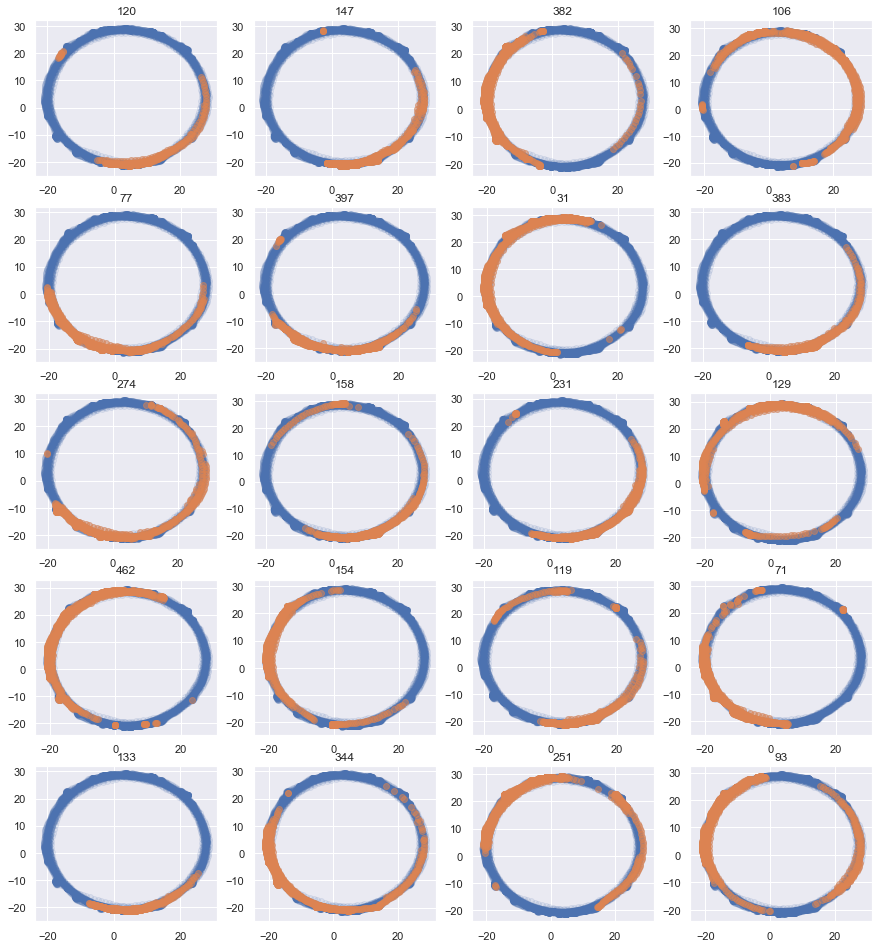

In [36]:
n = len(full_data)
new_data = full_data#.iloc[n // 2:]

quantiles = new_data[cols].quantile(0.85)

plt.figure(figsize=(15, 20))

for i, col in enumerate(cols):
    plt.subplot(6, 4, i + 1)
    plt.title(col)
    
    quantile = quantiles[col]
    active_state = (new_data[col] > quantile).values
    plt.scatter(new_data['x'], new_data['y'], alpha=0.1)
    plt.scatter(new_data[active_state].x, new_data[active_state].y, alpha=.5)
# plt.title('Best MI neurons')

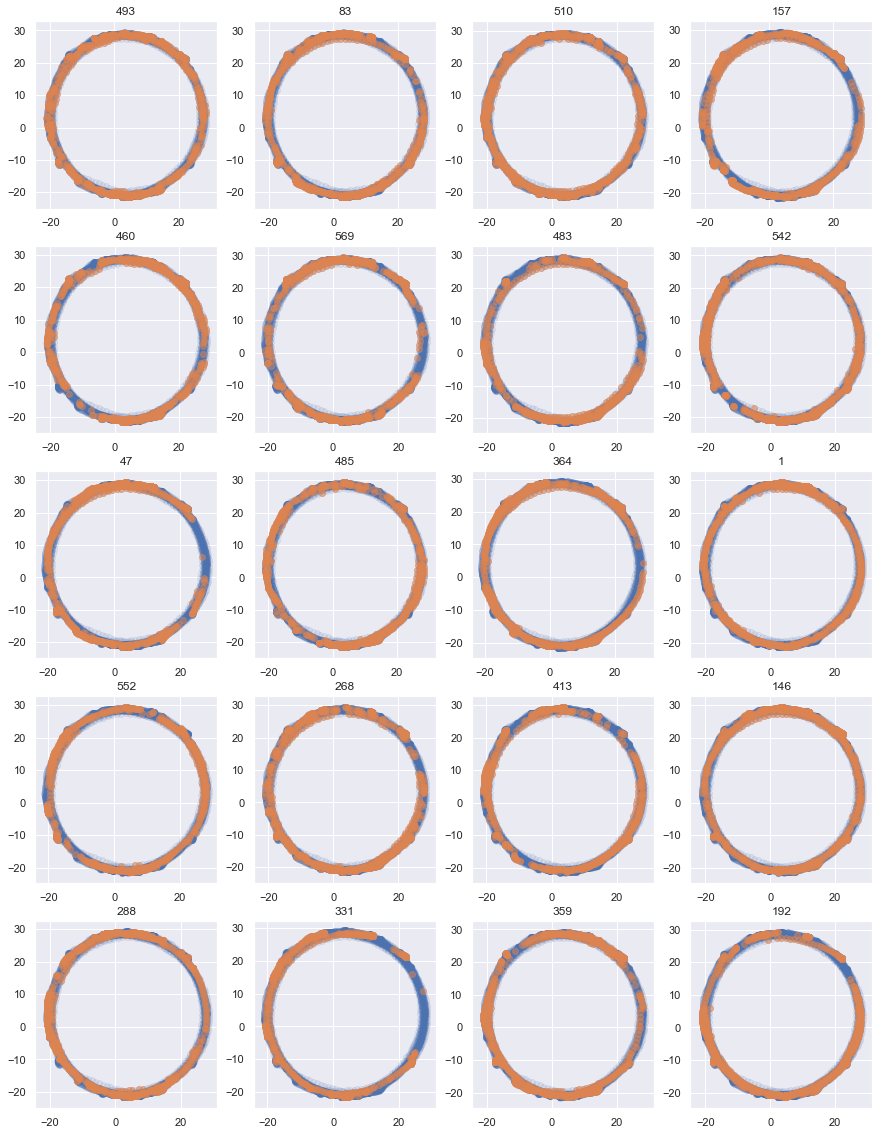

In [37]:
worst_cols = [col for col, _ in sorted(mis.items(), key=lambda x: x[1])][:20]

n = len(full_data)
new_data = full_data#.iloc[n // 2:]

quantiles = new_data[worst_cols].quantile(0.85)

plt.figure(figsize=(15, 20))

for i, col in enumerate(worst_cols):
    plt.subplot(5, 4, i + 1)
    plt.title(col)
    
    quantile = quantiles[col]
    active_state = (new_data[col] > quantile).values
    plt.scatter(new_data['x'], new_data['y'], alpha=0.1)
    plt.scatter(new_data[active_state].x, new_data[active_state].y, alpha=.5)
# plt.title('Worst MI neurons')

In [38]:
bad_cols = [129, 119, 93, 382]
new_cols = list(set(cols) - set(bad_cols))

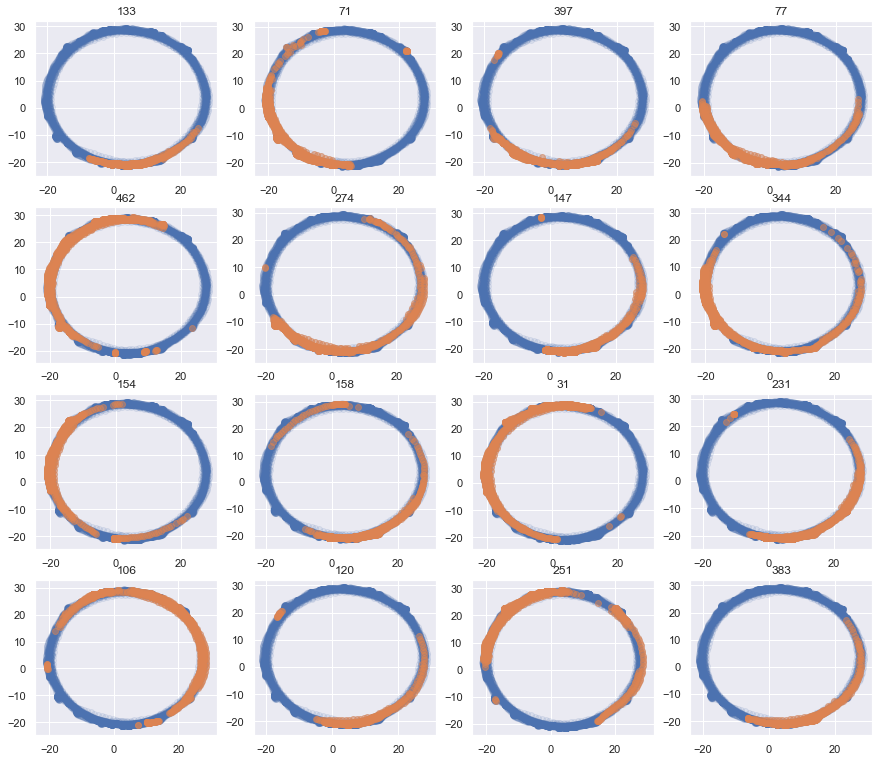

In [39]:
n = len(full_data)
new_data = full_data#.iloc[n // 2:]

quantiles = new_data[cols].quantile(0.85)

plt.figure(figsize=(15, 20))

for i, col in enumerate(set(cols) - set(bad_cols)):
    plt.subplot(6, 4, i + 1)
    plt.title(col)
    
    quantile = quantiles[col]
    active_state = (new_data[col] > quantile).values
    plt.scatter(new_data['x'], new_data['y'], alpha=0.1)
    plt.scatter(new_data[active_state].x, new_data[active_state].y, alpha=.5)
# plt.title('Neurons with single-linked active area')

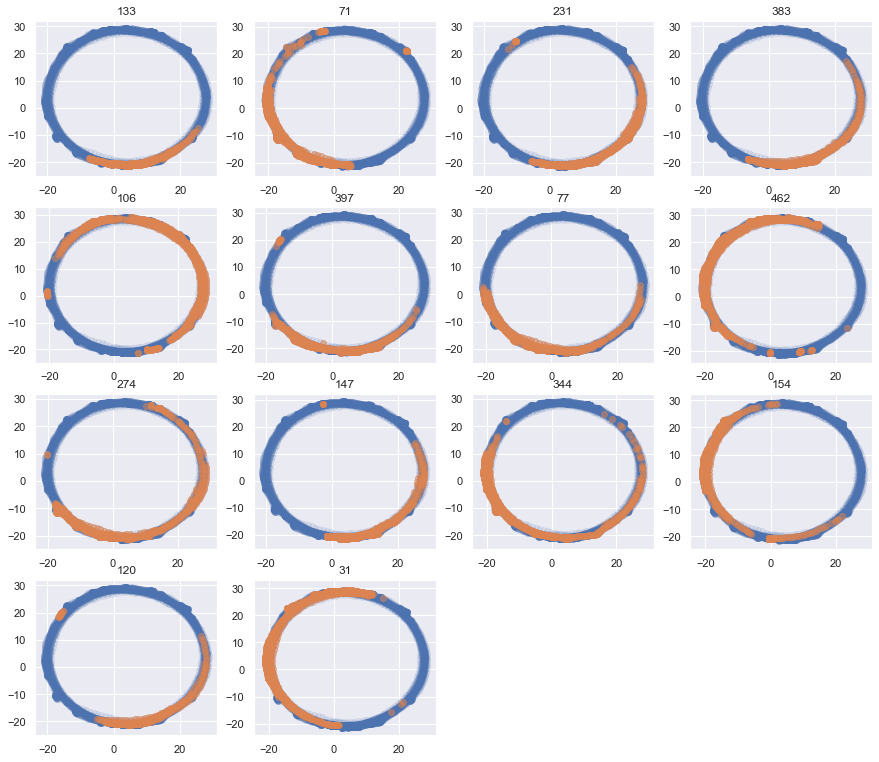

In [40]:
n = len(full_data)
new_data = full_data#.iloc[n // 2:]

quantiles = new_data[cols].quantile(0.85)

plt.figure(figsize=(15, 20))

for i, col in enumerate(set(cols) - set(bad_cols + [158, 251])):
    plt.subplot(6, 4, i + 1)
    plt.title(col)
    
    quantile = quantiles[col]
    active_state = (new_data[col] > quantile).values
    plt.scatter(new_data['x'], new_data['y'], alpha=0.1)
    plt.scatter(new_data[active_state].x, new_data[active_state].y, alpha=.5)
# plt.title('Neurons with single-linked active area')

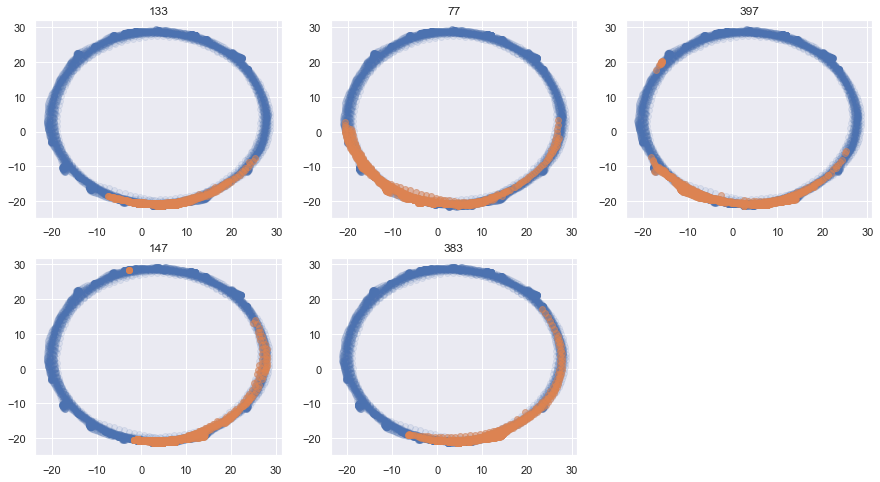

In [41]:
one_side_neurons = [133, 77, 397, 147, 383]

n = len(full_data)
new_data = full_data#.iloc[n // 2:]

quantiles = new_data[one_side_neurons].quantile(0.85)

plt.figure(figsize=(15, 8))

for i, col in enumerate(one_side_neurons):
    plt.subplot(2, 3, i + 1)
    plt.title(col)
    
    quantile = quantiles[col]
    active_state = (new_data[col] > quantile).values
    plt.scatter(new_data['x'], new_data['y'], alpha=0.1)
    plt.scatter(new_data[active_state].x, new_data[active_state].y, alpha=.5)
# plt.title('Neurons with single-linked active area')

In [42]:
n = full_data.shape[0]
train_size = 0.7
train, test = full_data.loc[:train_size * n], full_data.loc[train_size * n:]

In [43]:
X_train, y_train, X_test, y_test = train[cols], get_y(train[y_cols]), test[cols], get_y(test[y_cols])

In [44]:
def get_y_float(y, n=10):
    return (np.angle((y.x + 1j * y.y).values) + np.pi) / 2 / np.pi * 10

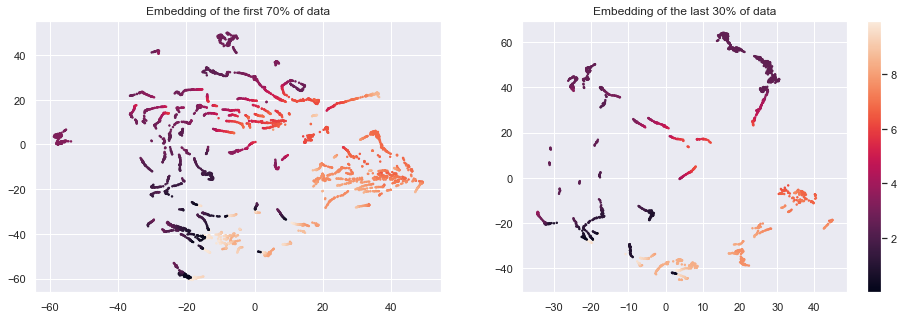

In [45]:
np.random.seed(43)
X_embedded = TSNE(n_components=2, perplexity=100).fit_transform(full_data[cols])
m = len(X_embedded)
plt.figure(figsize=(16,5))
plt.subplot(1, 2, 1)
plt.scatter(X_embedded[:int(0.7*m), 0], X_embedded[:int(0.7*m), 1], s=2, c=get_y_float(full_data)[:int(0.7*m)])
plt.title('Embedding of the first 70% of data')
plt.subplot(1, 2, 2)
plt.scatter(X_embedded[int(0.7*m):, 0], X_embedded[int(0.7*m):, 1], s=2, c=get_y_float(full_data)[int(0.7*m):])
plt.title('Embedding of the last 30% of data')
plt.colorbar()

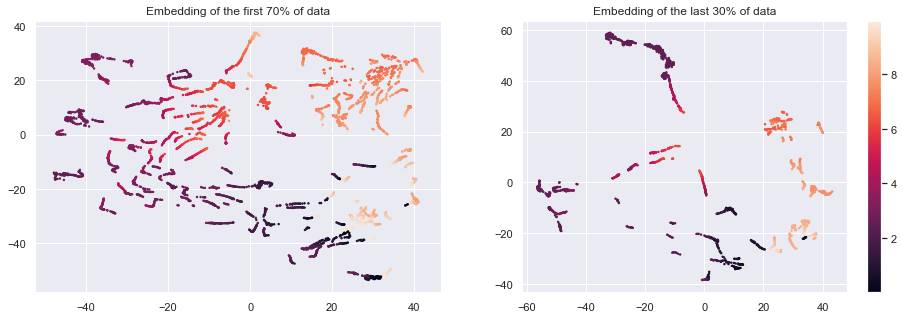

In [46]:
new_cols = list(set(cols) - set(bad_cols))
np.random.seed(42)
X_embedded = TSNE(n_components=2, perplexity=100).fit_transform(full_data[cols])
m = len(X_embedded)
plt.figure(figsize=(16,5))
plt.subplot(1, 2, 1)
plt.scatter(X_embedded[:int(0.7*m), 0], X_embedded[:int(0.7*m), 1], s=2, c=get_y_float(full_data)[:int(0.7*m)])
plt.title('Embedding of the first 70% of data')
plt.subplot(1, 2, 2)
plt.scatter(X_embedded[int(0.7*m):, 0], X_embedded[int(0.7*m):, 1], s=2, c=get_y_float(full_data)[int(0.7*m):])
plt.title('Embedding of the last 30% of data')
plt.colorbar()

In [47]:
get_y_float(full_data)[int(0.7*m):]

array([7.86003162, 7.89753934, 7.93850973, ..., 7.68772837, 7.73210717,
       7.77729972])

In [48]:
cls = CatBoostClassifier(iterations=100, loss_function='MultiClass', eval_metric='Accuracy')
cls.fit(X_train, y_train)

0:	learn: 0.5926013	total: 82.9ms	remaining: 8.21s
1:	learn: 0.6846172	total: 118ms	remaining: 5.79s
2:	learn: 0.6960899	total: 144ms	remaining: 4.65s
3:	learn: 0.7148209	total: 164ms	remaining: 3.93s
4:	learn: 0.7281667	total: 182ms	remaining: 3.46s
5:	learn: 0.7459611	total: 199ms	remaining: 3.12s
6:	learn: 0.7588387	total: 218ms	remaining: 2.9s
7:	learn: 0.7614142	total: 235ms	remaining: 2.71s
8:	learn: 0.7660969	total: 255ms	remaining: 2.58s
9:	learn: 0.7768672	total: 276ms	remaining: 2.49s
10:	learn: 0.7824865	total: 299ms	remaining: 2.42s
11:	learn: 0.7923203	total: 331ms	remaining: 2.43s
12:	learn: 0.7955982	total: 361ms	remaining: 2.41s
13:	learn: 0.7953641	total: 381ms	remaining: 2.34s
14:	learn: 0.7967689	total: 400ms	remaining: 2.27s
15:	learn: 0.8075392	total: 420ms	remaining: 2.21s
16:	learn: 0.8063685	total: 437ms	remaining: 2.13s
17:	learn: 0.8082416	total: 456ms	remaining: 2.08s
18:	learn: 0.8117537	total: 477ms	remaining: 2.03s
19:	learn: 0.8112854	total: 495ms	remaini

In [49]:
def best_constant_answer(y, metric):
    max_acc = 0
    max_y = 0
    for i in np.unique(y):
        y_pred = np.ones(len(y)) * i
        acc = metric(y_pred, y)
        if acc > max_acc:
            max_acc, max_y = acc, y_pred
    return max_y

In [50]:
y_preds = [
    (cls.predict(X_test).reshape(-1), 'GBDT'),
    (np.random.choice(y_train, len(y_test)), 'Random from train distribution'),
    (np.random.choice(y_test, len(y_test)), 'Random from test distribution'),
    (best_constant_answer(y_test, acc_1), 'Best constant answer'),
]

pd.DataFrame([
    [name, acc_1(y_pred, y_test), acc_3(y_pred, y_test)]
    for y_pred, name in y_preds
], columns=['Name', '1-accuracy', '3-accuracy']).set_index('Name')

,1-accuracy,3-accuracy
Name,,
GBDT,0.577007,0.968547
Random from train distribution,0.131236,0.335683
Random from test distribution,0.183297,0.345987
Best constant answer,0.368221,0.503254


In [52]:
explainer = shap.TreeExplainer(cls)
shap_values = explainer.shap_values(X_test)

ValueError: could not broadcast input array from shape (1279) into shape (703)

In [ ]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [ ]:
from sklearn.preprocessing import quantile_transform

In [ ]:
set(cols) - set(new_cols)

In [ ]:
data = quantile_transform(full_data[cols])
new_data = quantile_transform(full_data[new_cols])
y = full_data[y_cols]

In [ ]:
from dionysus import Filtration, homology_persistence, init_diagrams, Simplex
from collections import Counter
from hamming_diagrams import get_cycles

In [ ]:
def get_all_subsets(arr):
    n = len(arr)
    for i in range(1, 2**n):
        a = (np.array(list(reversed(bin(int(i))[2:]))) == '1')
        a.resize(n)
        yield tuple(arr[a].tolist())

In [ ]:
def get_cycles(filtration, end_time=np.inf):
    m = homology_persistence(filtration, prime=2)
    dgms = init_diagrams(m, filtration)
    cycles = []
    for i, dgm in enumerate(dgms):
        for pt in dgm:
            cycles.append((i, pt.birth, pt.death))
    cycles = pd.DataFrame(cycles, columns=['dimension', 'birth_time', 'death_time'])
    cycles['living_time'] = cycles['death_time'] - cycles['birth_time']
    inf_life = (cycles['living_time'] == np.inf)
    cycles['living_time'][inf_life] = end_time - cycles['birth_time'][inf_life]
    return cycles.sort_values('living_time', ascending=False)

In [ ]:
def construct_cycles(data):
    all_cycles = []
    for common_sec in np.arange(5, 0.9, -1):
        common_cnt = common_sec * 10
        filtration = Filtration()
        arr = set()
        for alpha in np.arange(0.95, 0.5, -0.01):
            neuron_activity = (data > alpha)
            sims = np.sum(neuron_activity * 2**np.arange(neuron_activity.shape[1]), axis=1)
            c = Counter(sims)
            sims = []
            for sim, cnt in c.items():
                if cnt > common_cnt:
                    sims.append(np.where(np.array(list(reversed(bin(int(sim))[2:]))) == '1')[0])

            cur_arr = []
            for sim in sims:
                for s in get_all_subsets(sim):
                    cur_arr.append(s)

            cur_arr = sorted(list(set(cur_arr) - arr), key=lambda x: len(x))
            for sim in cur_arr:
                filtration.append(Simplex(sim, 1 - alpha))
        cycles = get_cycles(filtration, 0.5)
        cycles.columns = ['%s_%.2f' % (col, float(common_cnt) / len(data) * 100) for col in cycles.columns]
        all_cycles.append(cycles)
    
    df = all_cycles[0].reset_index(drop=True)
    for i, c in enumerate(all_cycles[1:]):
        df = df.join(c.reset_index(drop=True), how='outer')
    return all_cycles, df

In [ ]:
len(mis.items())

In [ ]:
worst_cols = [col for col, _ in sorted(mis.items(), key=lambda x: x[1])][:60]
worst_data = quantile_transform(full_data[worst_cols])

construct_cycles(worst_data)[1].T

In [ ]:
worst_data = quantile_transform(full_data[one_side_neurons])

construct_cycles(worst_data)[1].T

In [ ]:
def to_str(x):
    if isinstance(x, int):
        return str(x)
    else:
        return "%.2f" % x

for x in df:
    o = df[x]
    print(x + ' & ' + ' & '.join([to_str(a) for a in o][:12]) + ' \\\\')
#     print(int(o['dimension']), o['birth_time'], o['death_time'], o['living_time'])

In [ ]:
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

In [ ]:
def plot_cycles(all_cycles):
    c_map = {
        0: 'blue',
        1: 'red',
        2: 'green',
        3: 'black',
        4: 'yellow'
    }


    # legend_elements = [mpatches.Patch(color=c, edgecolor='#000000') for c, d in c_map.items()]

    plt.figure(figsize=(15, 7))
    
    for i, cycles in enumerate(all_cycles):
        plt.subplot(2, 3, i + 1)
        
        if i == 0:
            for d, c in c_map.items():
                plt.scatter([-1], [-1], c=c, label=f'dim={d}')
        
        x = cycles.values
        x[x == np.inf] = 0.5
        plt.scatter(x[:, 1], x[:, 2], c=[c_map[y] for y in x[:, 0]])
    #     for x in cycles.values:
    #         x[x == np.inf] = 0.5
    #         plt.plot([x[1], x[1]], [x[1], x[2]], c=c_map[x[0]], markersize=3, marker='o')
        q = np.arange(0.0, 0.6, 0.01)
        plt.plot(t, t, '--', c='grey')
        plt.xlabel('Birth time')
        plt.ylabel('Death time')
        plt.xlim(0, 0.6)
        plt.ylim(0, 0.6)
#         plt.xscale(0.5)
#         plt.yscale(0.5)

    # plt.subplot(2, 3, 6)
    # plt.legend(legend_elements)
    legend_elements = [Line2D([0], [0], c=c, label=f'dim = {d}') for d, c in c_map.items()]
#     print(c_map.items(), legend_elements)
            
#     plt.figlegend(legend_elements, labels=[f'dim={i}' for i in range(5)], loc = 'lower center', ncol=5, labelspacing=0. )
    plt.figlegend(loc='lower right', bbox_to_anchor=(0.75, 0.15))
    # plt.legend(handles=legend_elements)

In [ ]:
plot_cycles(all_cycles_1)

In [ ]:
new_data = quantile_transform(full_data[new_cols])
all_cycles_1, df_1 = construct_cycles(new_data)
plot_cycles(all_cycles_1)

In [ ]:
new_data = quantile_transform(full_data[list(set(cols) - set(bad_cols + [158, 251, 120]))])
all_cycles_3, df_3 = construct_cycles(new_data)
plot_cycles(all_cycles_1)

In [ ]:
new_data = quantile_transform(full_data[cols])
all_cycles_2, df_2 = construct_cycles(new_data)
plot_cycles(all_cycles_2)

In [ ]:
df_2.T

In [ ]:
for x in df:
    o = df[x]
    print(x + ' & ' + ' & '.join([to_str(a) for a in o][:9]) + ' \\\\')